In [17]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
warnings.filterwarnings('ignore')
import time as timer
start_all = timer.time()

In [18]:
dataf ="/Volumes/ESA_F4R/era/" 
datao ="/Volumes/ESA_F4R/ed_prepare/" 
datap ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/plots/era/"

In [19]:
#For selection and plotting
YR = 2000
time_bnds = (str(YR)+'-01-01',str(YR)+'-12-31')
lon_bnds, lat_bnds = (14, 31), (6,-11)
lon_bnds_f, lat_bnds_f = (15, 30), (-10,5) 
p_bnds = (30000,100000)

In [20]:
#Open era input and rho datasets
rho = xr.open_dataset(datao+"rho_era5_"+str(YR)+".nc")['rho']
ds = xr.open_dataset(datao+"erads_"+str(YR)+".nc")

In [21]:
#Prepping datasets near surface for recycling
import bulk_recycling_model.numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

In [22]:
# Prepare and scale the data
from bulk_recycling_model import preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

# make a scaling object to convert between unit systems
scaling = Scaling(H)

dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

# convert E to scaled units
#print('pre-scaled',ds['Evap'])
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

L = 1.66e+06 m
dx = 2.73e+04 m
H = 1.66e+06 m
dy = 2.73e+04 m
dx = 1.64e-02 scaled
dy = 1.64e-02 scaled


0 2000-01-01T00:00:00.000000000


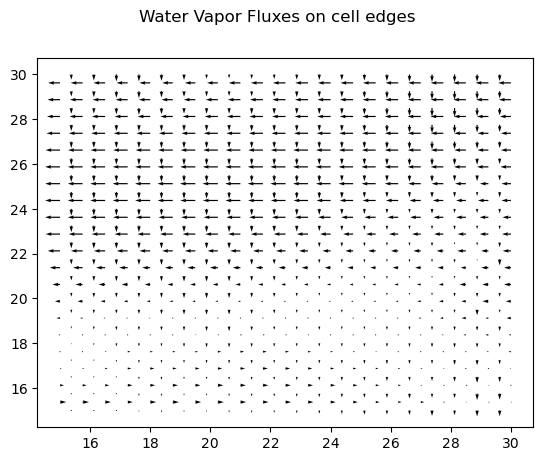

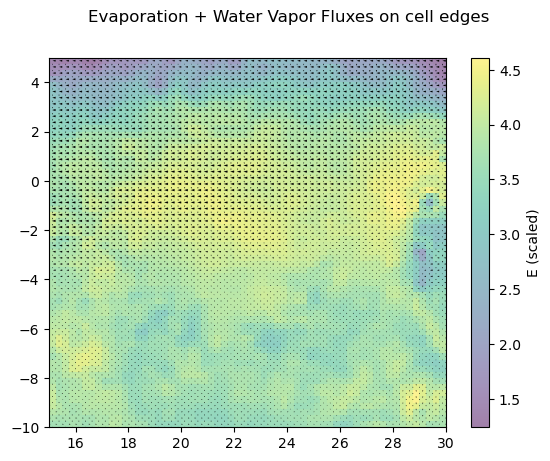

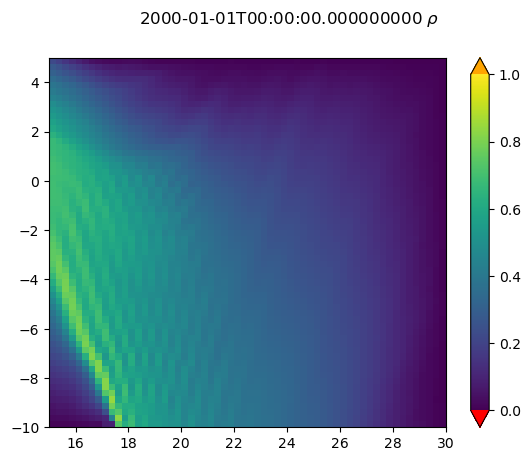

1 2000-02-01T00:00:00.000000000


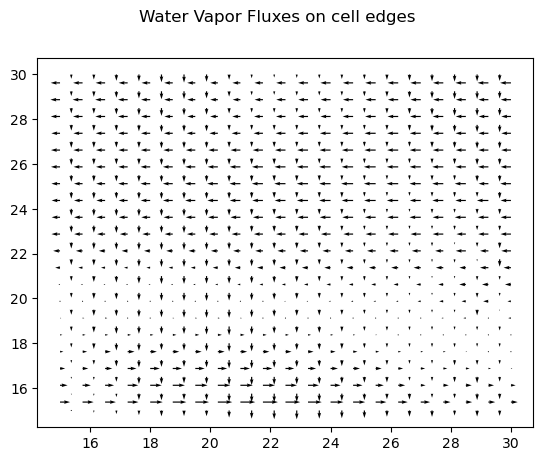

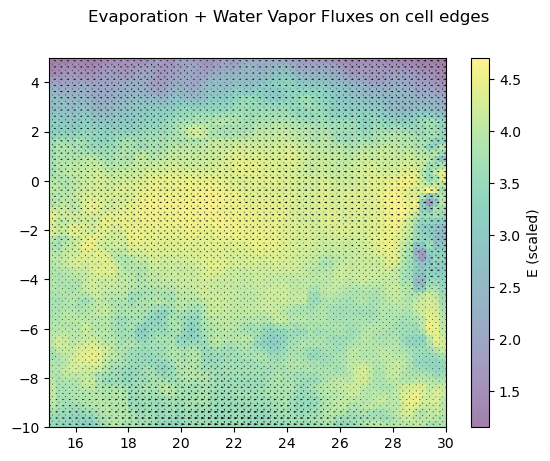

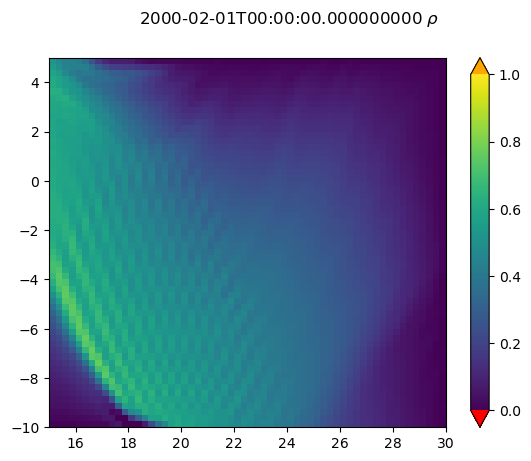

2 2000-03-01T00:00:00.000000000


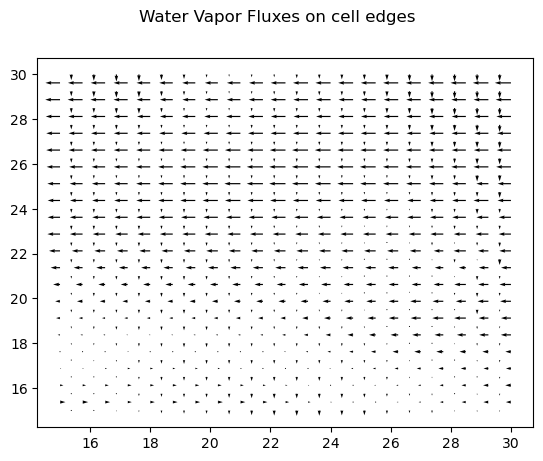

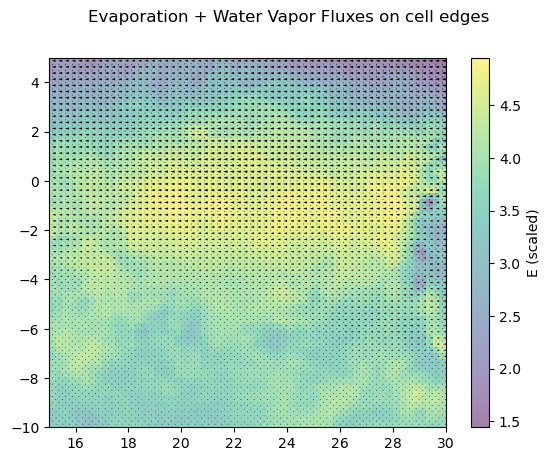

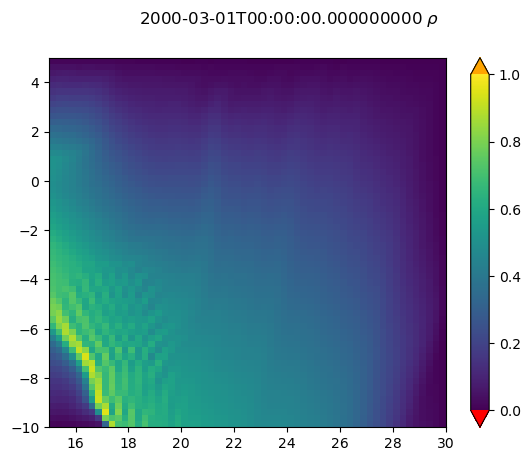

3 2000-04-01T00:00:00.000000000


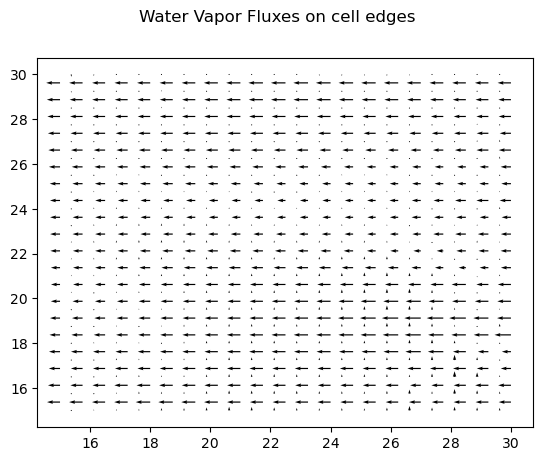

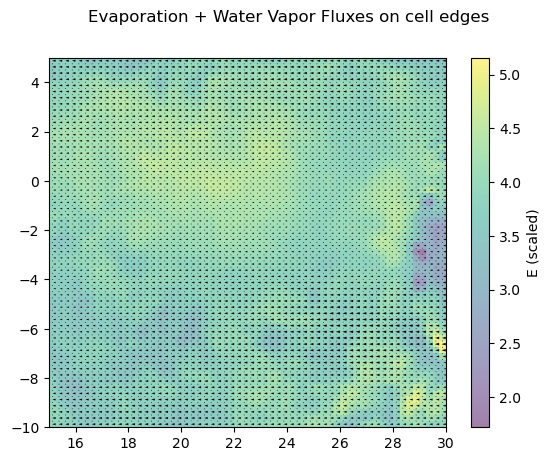

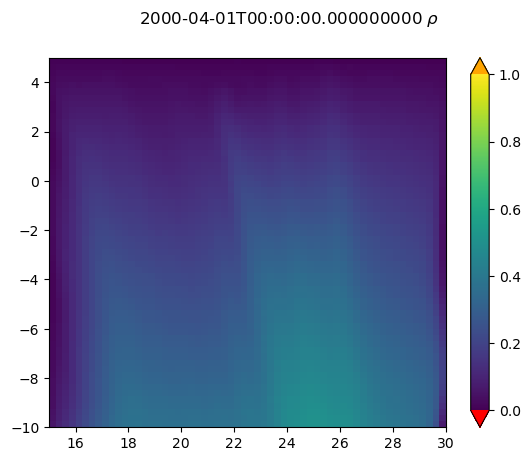

4 2000-05-01T00:00:00.000000000


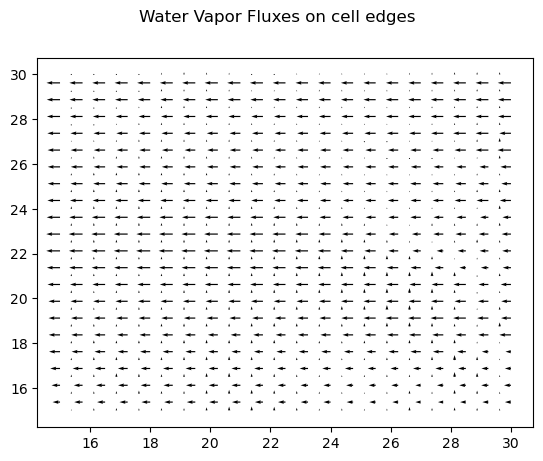

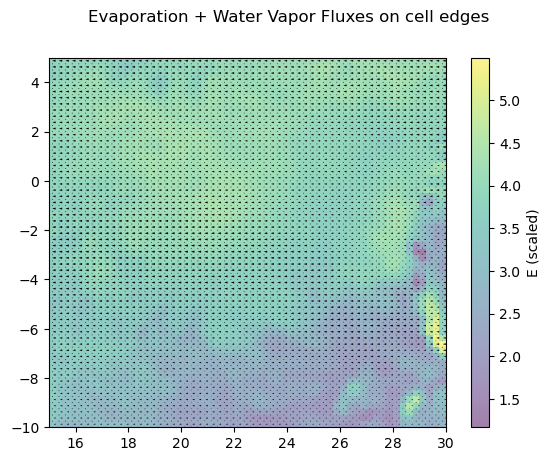

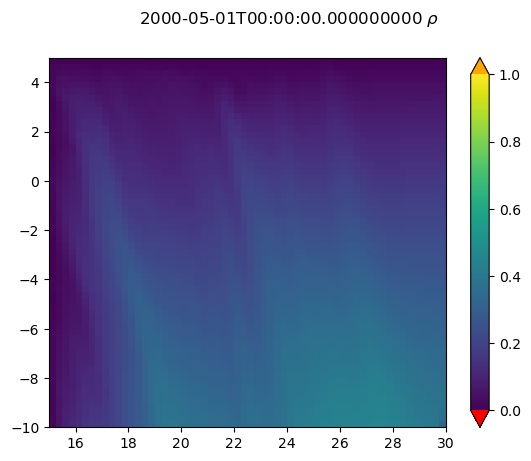

5 2000-06-01T00:00:00.000000000


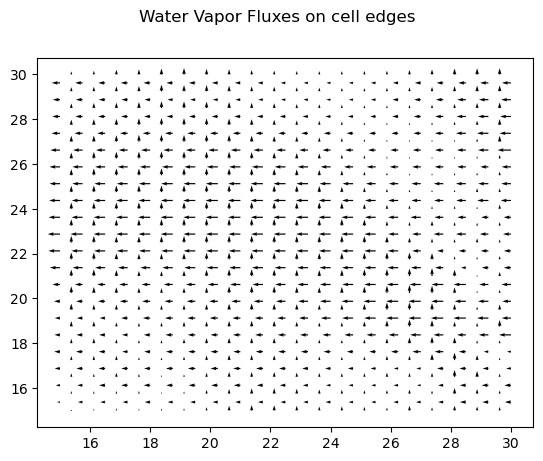

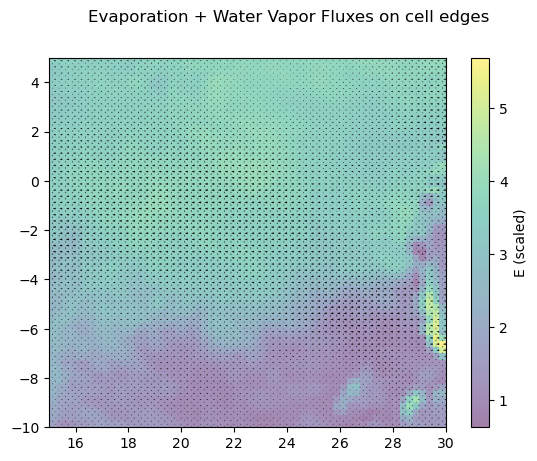

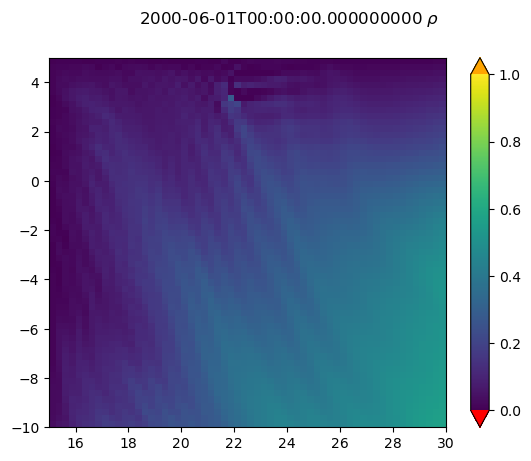

6 2000-07-01T00:00:00.000000000


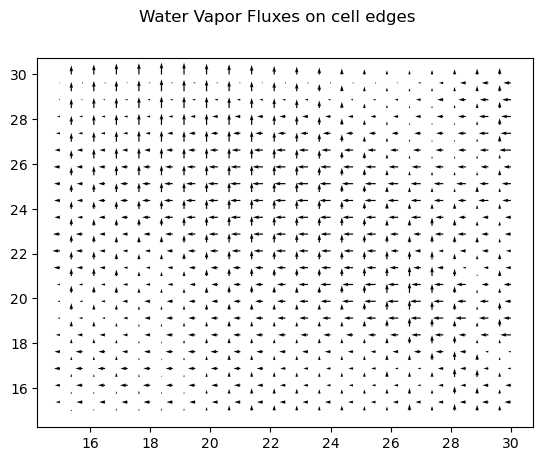

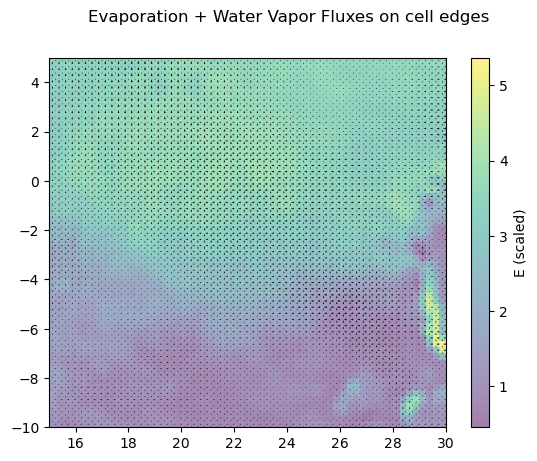

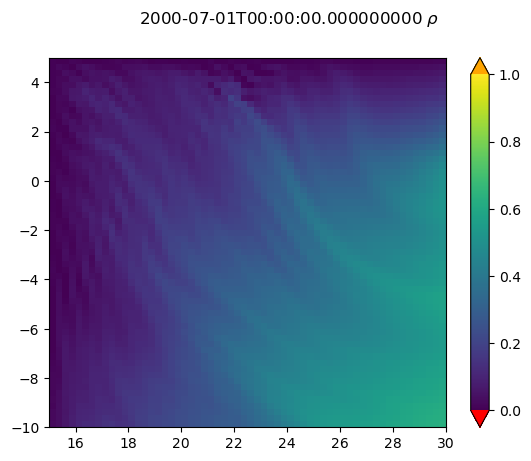

7 2000-08-01T00:00:00.000000000


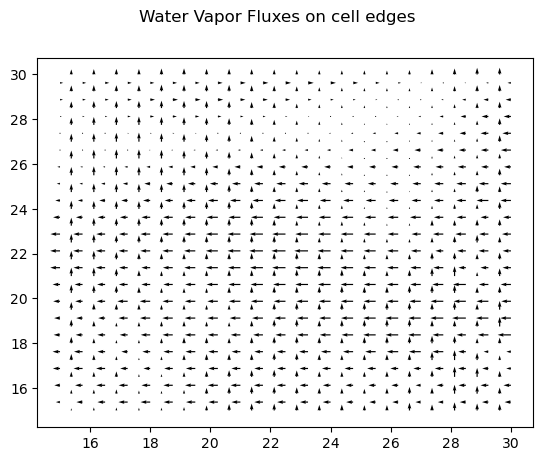

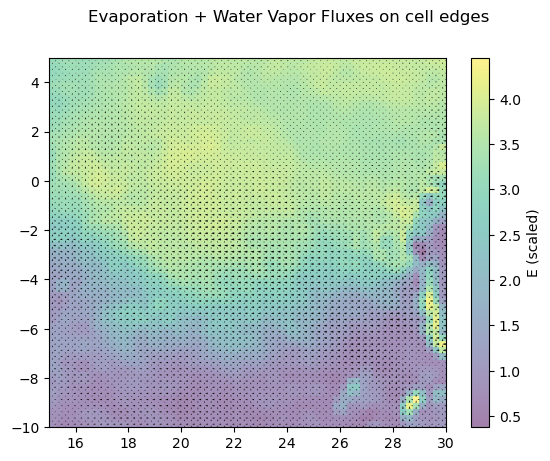

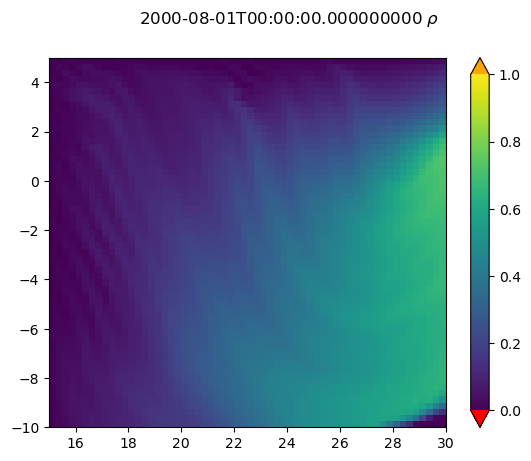

8 2000-09-01T00:00:00.000000000


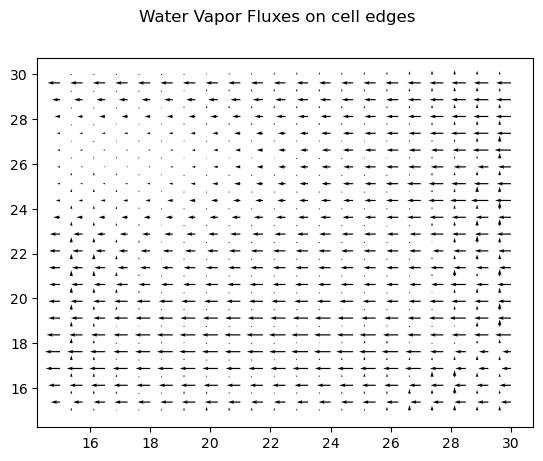

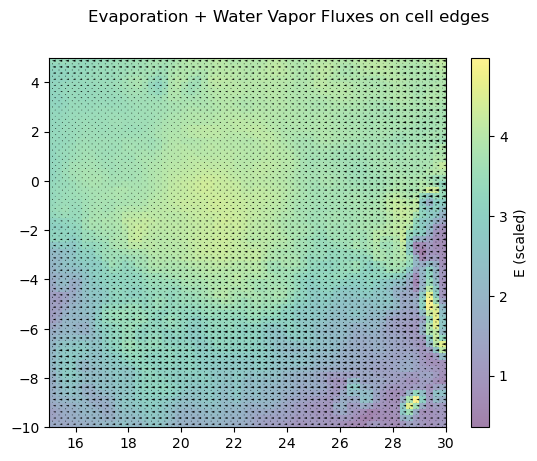

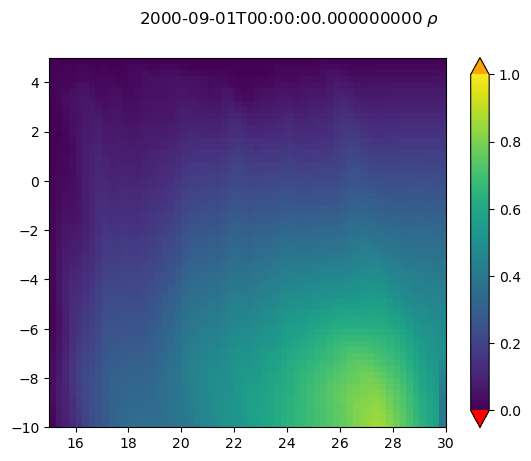

9 2000-10-01T00:00:00.000000000


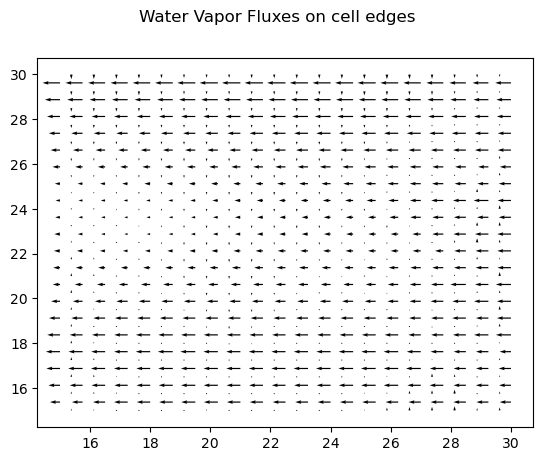

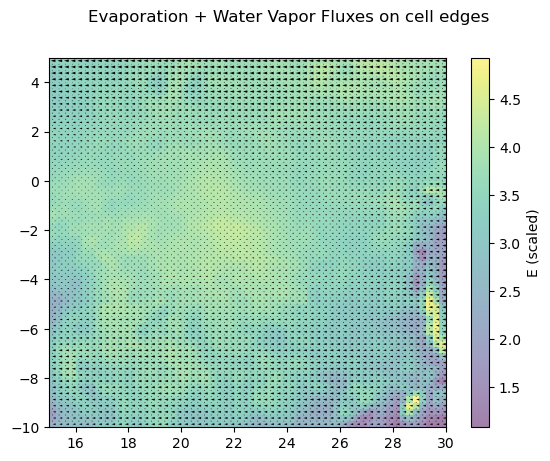

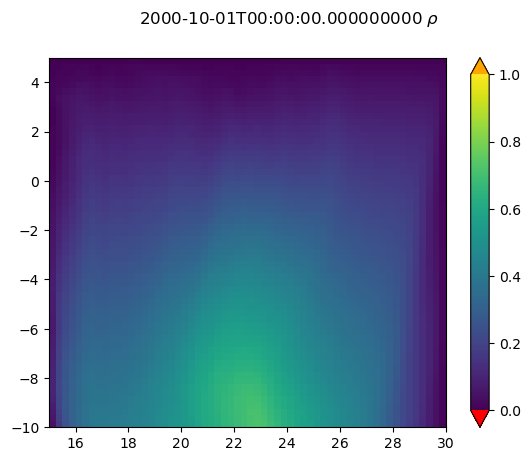

10 2000-11-01T00:00:00.000000000


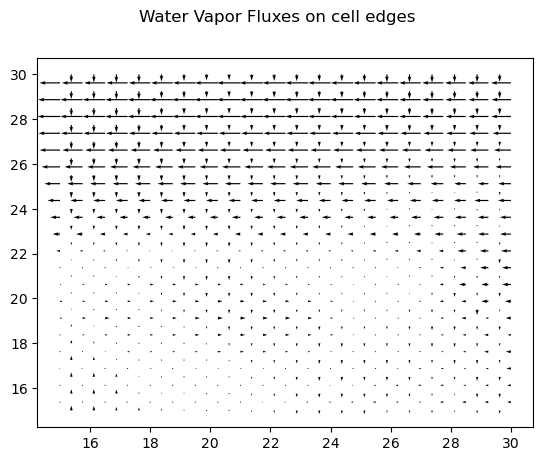

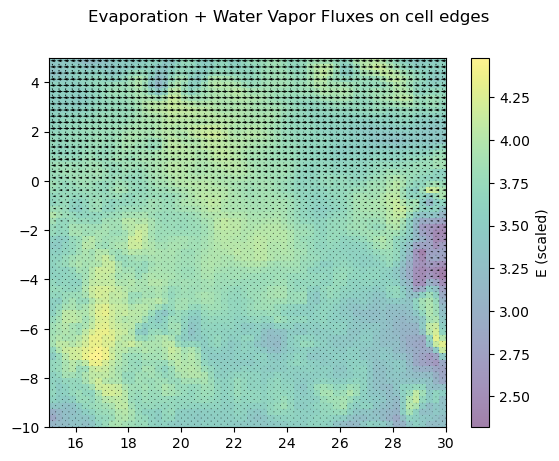

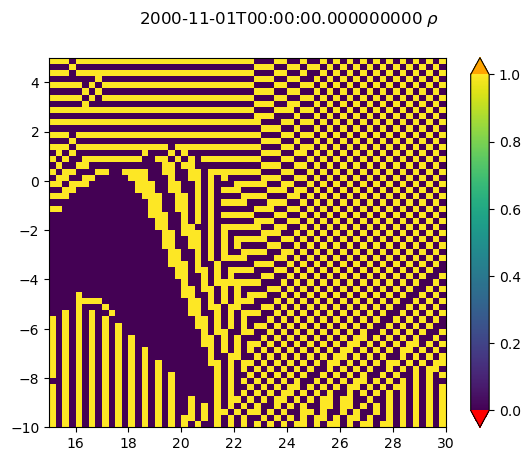

11 2000-12-01T00:00:00.000000000


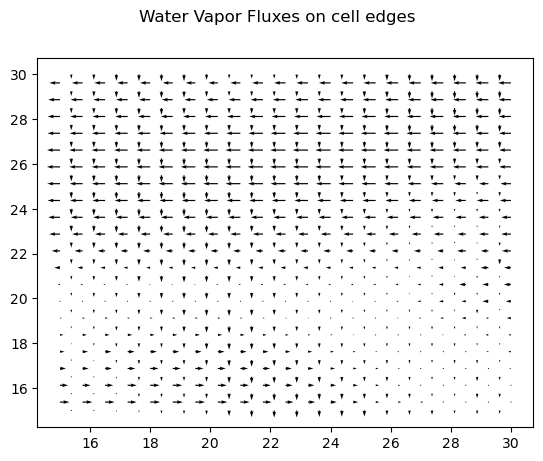

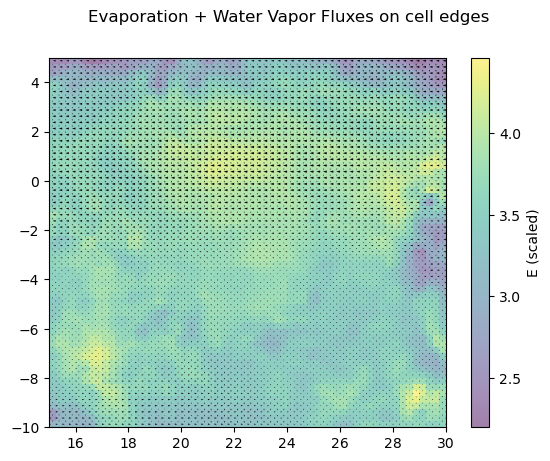

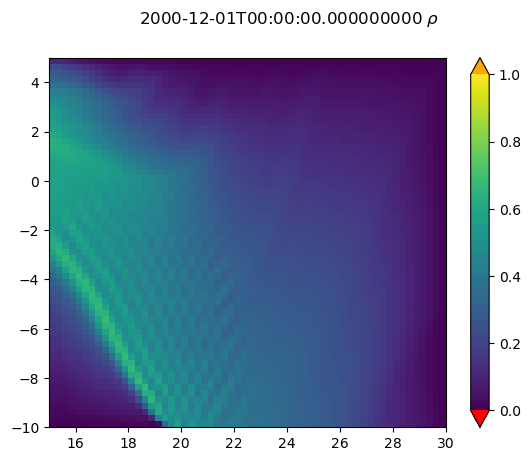

In [23]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run

rho_ar = np.empty((np.shape(E)[0]-1,np.shape(E)[1]-1,np.shape(E)[2]))
#Entering preprocessing and time step loop
#Run model and plot
for i,time in enumerate(ds.time):
    print(i,time.values)
    # preprocess E onto the secondary grid
    Ei = preprocess.prepare_E(E[:,:,i])
    
    # preprocess water vapor fluxes onto the secondary grid
    Fxi_left = preprocess.prepare_Fx_left(Fx[:,:,i])
    Fxi_right = preprocess.prepare_Fx_right(Fx[:,:,i])
    Fyi_bottom = preprocess.prepare_Fy_bottom(Fy[:,:,i])
    Fyi_top = preprocess.prepare_Fy_top(Fy[:,:,i])
    
    # compute P
    Pi = preprocess.calculate_precipitation(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, Ei, dx, dy)

    # Create a quiver plot
    fig, ax = plt.subplots()
    U,V = plotting.build_uv_fluxes(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top)
    X, Y = np.meshgrid(lon_axis.half_step, lon_axis.half_step, indexing="ij")
    ax.quiver(X[::3, ::3],Y[::3, ::3],U[::3, ::3],V[::3, ::3])
    fig.suptitle("Water Vapor Fluxes on cell edges")
    
    # Create a quiver plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Ei, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="E (scaled)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")
    
    # plot each timestep 
    fig, ax = plt.subplots()
    cmap=plt.cm.viridis
    cmap.set_extremes(under='red', over='orange')
    collection = plotting.pcolormesh(ax, rho.sel(time=time), lon_axis, lat_axis,
                                     vmin=0.0, vmax=1,
                                     cmap=cmap)
    fig.colorbar(collection,extend='both')
    fig.suptitle(str(time.values)+" $\\rho$")
    #plt.savefig(datap+"rho_"+str(time.values)+".png")
    plt.show()
    plt.close()
    

**Create and save rho xarray file**

- Create an xarray to store all of the calculated recycling ratios that is organised in an easy to plot/interpret format
- Count number of values in array over 1 - replace all of these with 1
- Count number of negative rho values - replace all of these with zero
- Save to file

In [24]:
print('Number of rhos over 1: ', rho.where(rho.values>1.0).count().values)
print('Number of negative rhos: ', rho.where(rho.values<0.0).count().values)
rho_xarr = rho.where(rho.values<=1.0,1.0)
rho_xarr = rho.where(rho.values>0.0,0.0)
print('Number of rhos over 1: ', rho.where(rho.values>1.0).count().values)
print('Number of negative rhos: ', rho.where(rho.values<0.0).count().values)
#rho.to_netcdf(datao+"rho_no_era5_"+str(YR)+".nc")

Number of rhos over 1:  0
Number of negative rhos:  0
Number of rhos over 1:  0
Number of negative rhos:  0


**Plotting**

Create seasonal arrays and plot these

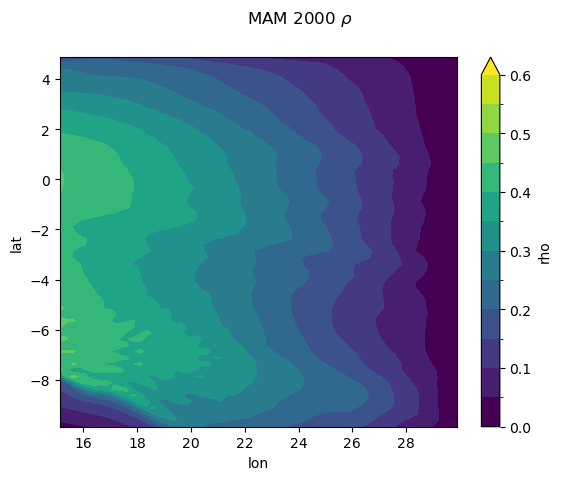

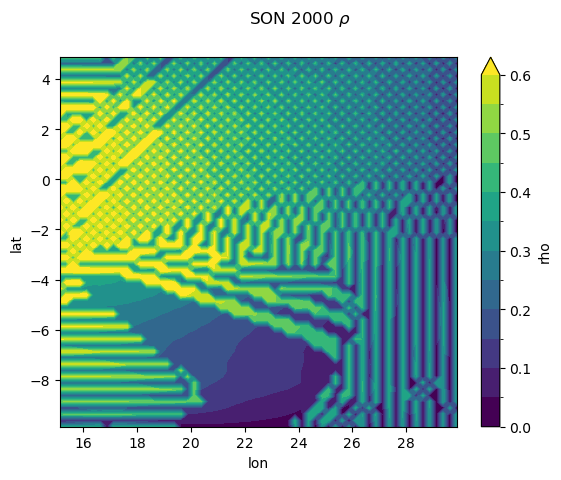

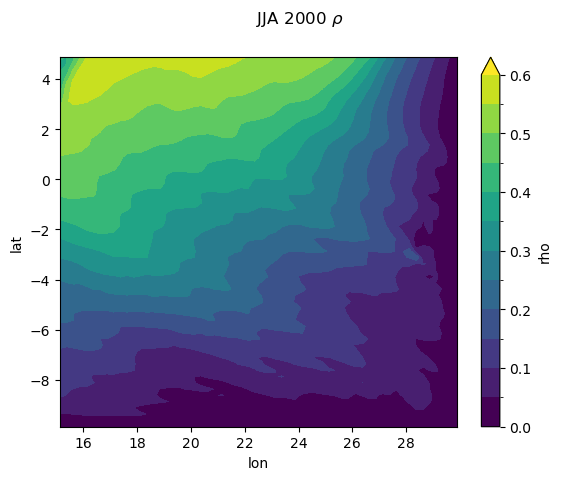

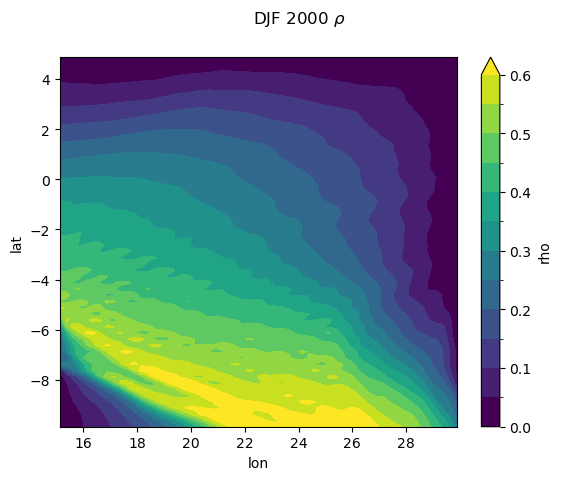

In [25]:

mam_rho = rho.sel(time=rho_xarr.time.dt.month.isin([3,4,5]))
fig, ax = plt.subplots()
collection = mam_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("MAM "+str(YR)+" $\\rho$")
#plt.savefig(datao+"rho_MAM_"+str(YR)+".png")
plt.show()
    
son_rho = rho.sel(time=rho_xarr.time.dt.month.isin([9,10,11]))
fig, ax = plt.subplots()
collection = son_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("SON "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_SON_"+str(YR)+".png")
plt.show()

jja_rho = rho.sel(time=rho_xarr.time.dt.month.isin([6,7,8]))
fig, ax = plt.subplots()
collection = jja_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("JJA "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_JJA_"+str(YR)+".png")
plt.show()

djf_rho = rho.sel(time=rho_xarr.time.dt.month.isin([12,1,2]))
fig, ax = plt.subplots()
collection = djf_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("DJF "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_DJF_"+str(YR)+".png")
plt.show()

rho_xarr.close()

